In [662]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [663]:
from torchvision import transforms

from Net.source.utils.common_utils import plot_figures, torch2cv
from Net.source.hpatches_dataset import (
    HPatchesDataset,

    IMAGE1,
    IMAGE2,
    HOMO12,
    HOMO21,
    S_IMAGE1,
    S_IMAGE2
)
from Net.source.transforms import (
    ToPILImage,
    ColorJitter,
    GrayScale,
    Resize,
    RandomCrop,
    ToTensor
)
from Net.experiments.config import AnalyzeDatasetConfig

In [664]:
dataset_config = AnalyzeDatasetConfig().get()

item_transforms = [ToPILImage(),
                   ColorJitter(0.1, 0.1),
                   GrayScale(),
                   Resize((960, 1280)),
                   Resize((dataset_config.HEIGHT, dataset_config.WIDTH)),
                   ToTensor()]

dataset = HPatchesDataset(dataset_config.DATASET_ROOT,
                          dataset_config.CSV,
                          item_transforms=transforms.Compose(item_transforms),
                          include_sources=dataset_config.INCLUDE_SOURCES)

In [665]:
item = dataset.__getitem__(0)

image1 = item[IMAGE1]
image2 = item[IMAGE2]

homo12 = item[HOMO12]
homo21 = item[HOMO21]

s_image1 = item[S_IMAGE1]
s_image2 = item[S_IMAGE2]

In [666]:
from Net.source.utils.image_utils import warp_image

w_image1 = warp_image(image2.unsqueeze(0), image1.unsqueeze(0), homo21.unsqueeze(0)).squeeze(0)
w_image2 = warp_image(image1.unsqueeze(0), image2.unsqueeze(0), homo12.unsqueeze(0)).squeeze(0)

In [667]:
cv_image1 = torch2cv(image1, to_rgb=True)
cv_image2 = torch2cv(image2, to_rgb=True)

cv_s_image1 = torch2cv(s_image1)
cv_s_image2 = torch2cv(s_image2)

cv_w_image1 = torch2cv(w_image1, to_rgb=True)
cv_w_image2 = torch2cv(w_image2, to_rgb=True)

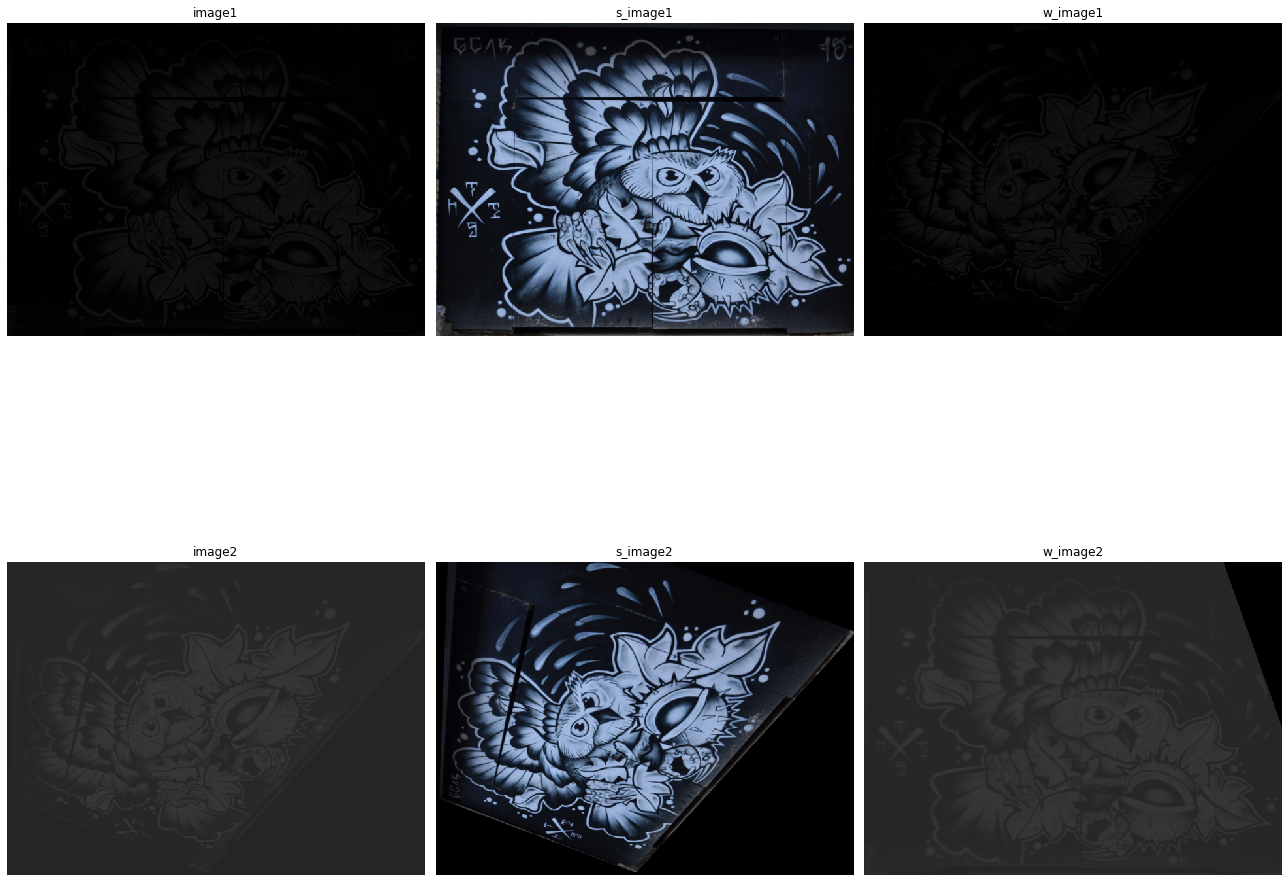

In [668]:
plot_figures({'image1': cv_image1, 's_image1': cv_s_image1, 'w_image1': cv_w_image1,
              'image2': cv_image2, 's_image2': cv_s_image2, 'w_image2': cv_w_image2}, 2, 3, (18, 18))

In [669]:
import numpy as np
import cv2 as cv

from math import pi
from scipy.stats import truncnorm
from skimage.morphology import erosion

def flat2mat(H):
    """
    Converts a flattened homography transformation with shape `[1, 8]` to its
    corresponding homography matrix with shape `[1, 3, 3]`.
    """
    return np.reshape(np.concatenate([H, np.ones([H.shape[0], 1])], axis=1), [3, 3])

def sample_homography(shape, perspective=True, scaling=True, rotation=True, translation=True,
                      n_scales=5, n_angles=25, scaling_amplitude=0.2, perspective_amplitude_x=0.2,
                      perspective_amplitude_y=0.2, patch_ratio=0.85, max_angle=pi / 2,
                      allow_artifacts=True, translation_overflow=0.):
    # Corners of the output image
    pts1 = np.stack([[0., 0.], [0., 1.], [1., 1.], [1., 0.]], axis=0)
    # Corners of the input patch
    margin = (1 - patch_ratio) / 2
    pts2 = margin + np.array([[0, 0], [0, patch_ratio],
                              [patch_ratio, patch_ratio], [patch_ratio, 0]])

    # Random perspective and affine perturbations
    if perspective:
        if not allow_artifacts:
            perspective_amplitude_x = min(perspective_amplitude_x, margin)
            perspective_amplitude_y = min(perspective_amplitude_y, margin)

        perspective_displacement = truncnorm(-2, 2, 0, perspective_amplitude_y / 2).rvs()

        h_displacement_left = truncnorm(-2, 2, 0., perspective_amplitude_x / 2).rvs()
        h_displacement_right = truncnorm(-2, 2, 0., perspective_amplitude_x / 2).rvs()

        pts2 += np.array([[h_displacement_left, perspective_displacement],
                          [h_displacement_left, -perspective_displacement],
                          [h_displacement_right, perspective_displacement],
                          [h_displacement_right, -perspective_displacement]])

    # Random scaling
    # sample several scales, check collision with borders, randomly pick a valid one
    if scaling:
        scales = np.concatenate([[1.], truncnorm(-2, 2, 1, scaling_amplitude / 2).rvs(n_scales)], 0)
        center = np.mean(pts2, axis=0, keepdims=True)
        scaled = np.expand_dims(pts2 - center, axis=0) * np.expand_dims(np.expand_dims(scales, 1), 1) + center

        if allow_artifacts:
            valid = np.arange(n_scales)  # all scales are valid except scale=1
        else:
            valid = np.where(np.logical_and.reduce((scaled >= 0.) & (scaled < 1.), (1, 2)))[0]

        idx = valid[np.random.randint(0, valid.shape[0])]
        pts2 = scaled[idx]

    # Random translation
    if translation:
        t_min, t_max = np.amin(pts2, axis=0), np.amin(1 - pts2, axis=0)

        if allow_artifacts:
            t_min += translation_overflow
            t_max += translation_overflow

        pts2 += np.expand_dims(np.stack([np.random.uniform(-t_min[0], t_max[0]),
                                         np.random.uniform(-t_min[1], t_max[1])]), axis=0)

    # Random rotation
    # sample several rotations, check collision with borders, randomly pick a valid one
    if rotation:
        angles = np.linspace(-max_angle, max_angle, n_angles)
        angles = np.concatenate([[0.], angles], axis=0)  # in case no rotation is valid
        center = np.mean(pts2, axis=0, keepdims=True)
        rot_mat = np.reshape(np.stack([np.cos(angles), -np.sin(angles),
                                       np.sin(angles), np.cos(angles)], axis=1), [-1, 2, 2])
        rotated = np.matmul(np.tile(np.expand_dims(pts2 - center, axis=0), [n_angles + 1, 1, 1]), rot_mat) + center
        if allow_artifacts:
            valid = np.arange(n_angles)  # all angles are valid, except angle=0
        else:
            valid = np.where(np.logical_and.reduce((rotated >= 0.) & (rotated < 1.), axis=(1, 2)))[0]
        idx = valid[np.random.randint(0, valid.shape[0])]
        pts2 = rotated[idx]

    # Rescale to actual size
    shape = shape[::-1]  # different convention [y, x]
    pts1 *= np.expand_dims(shape, axis=0)
    pts2 *= np.expand_dims(shape, axis=0)

    def ax(p, q):
        return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]

    def ay(p, q):
        return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

    a_mat = np.stack([f(pts1[i], pts2[i]) for i in range(4) for f in (ax, ay)], axis=0)
    p_mat = np.transpose(np.stack([[pts2[i][j] for i in range(4) for j in range(2)]], axis=0))
    homography = np.transpose(np.linalg.lstsq(a_mat, p_mat, rcond=None)[0])

    return flat2mat(homography)

In [670]:
h = sample_homography((640, 480))

In [671]:
w_cv_s_image2 = cv.warpPerspective(cv_s_image2, h, (640, 480))

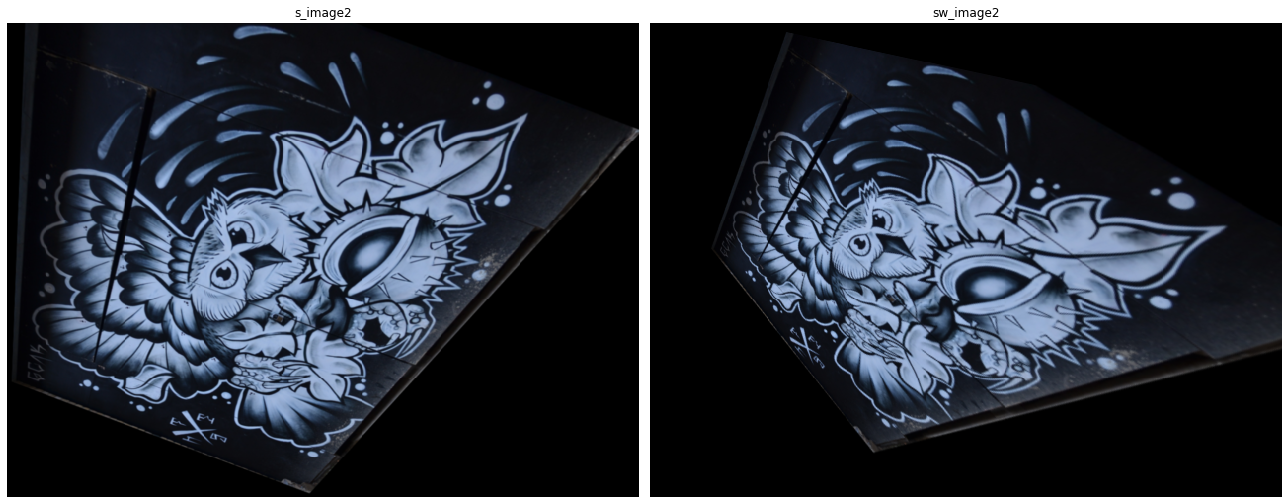

In [672]:
plot_figures({'s_image2': cv_s_image2, 'sw_image2': w_cv_s_image2}, 1, 2, (18, 18))

In [673]:
cv_s_image2.shape[1::-1]

(640, 480)